In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tyssue import config, Sheet, SheetGeometry, History
from tyssue.draw import sheet_view
from tyssue.generation import three_faces_sheet
from tyssue.draw.plt_draw import plot_forces

from tyssue.dynamics import PlanarModel

from tyssue.solvers.viscous import EulerSolver, IVPSolver
from tyssue.draw.plt_draw import create_gif

geom  = SheetGeometry
model = PlanarModel

This notebooks demonstrates usage of the time dependant solvers `EulerSolver` and `IVPSolver` in the simplest case where we solve
$$\eta_i \frac{d\mathbf{r}_i}{dt}  = \mathbf{F}_i = - \mathbf{\nabla}_i E$$

The model is defined in the same way it is defined for the quasistatic solver.

###  Simple forward Euler solver

$$\mathbf{r}_i(t+dt) = \mathbf{r}_i(t) + \frac{\mathbf{F}_i(t)}{\eta} dt$$


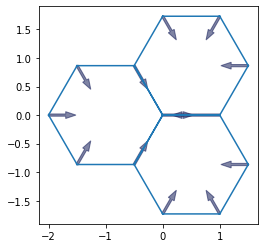

In [2]:
sheet = Sheet('3', *three_faces_sheet())
geom.update_all(sheet)
sheet.settings['threshold_length'] = 1e-3

sheet.update_specs(config.dynamics.quasistatic_plane_spec())
sheet.face_df["prefered_area"] = sheet.face_df["area"].mean()
history = History(sheet)

sheet.vert_df['viscosity'] = 1.0
sheet.edge_df.loc[[0, 17],  'line_tension'] *= 4

fig, ax = plot_forces(sheet, geom, model, ['x', 'y'], 1)

Solver instanciation

In [3]:
solver = EulerSolver(sheet, geom, model, with_t1=True, with_t3=True)



The solver's `solve` method accepts a `on_topo_change` function as argument. This function is executed each time a topology change occurs. Here, we reste the line tension to its original value.

In [4]:
def on_topo_change(sheet):
    print("reseting tension")
    sheet.edge_df["line_tension"] = sheet.specs["edge"]["line_tension"]


### Solving for $t = 0$ to $t = 8$

In [5]:

res = solver.solve(tf=8, dt=0.05, on_topo_change=on_topo_change,
                   topo_change_args=(solver.eptm,))

reseting tension


### Showing the results

In [6]:
create_gif(solver.history, "sheet3.gif")

![](sheet3.gif)


### Same problem with `IVPSolver`

This calls scipy's [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) under the hood. Benefits: optimal number of function calls. Problems: not side-effect safe (as there are more function calls than actual evaluation points).

In [7]:
sheet = Sheet('3', *three_faces_sheet())
geom.update_all(sheet)
sheet.settings['threshold_length'] = 1e-3

sheet.update_specs(config.dynamics.quasistatic_plane_spec())
sheet.face_df["prefered_area"] = sheet.face_df["area"].mean()
history = History(sheet)



sheet.vert_df['viscosity'] = 1.0
sheet.edge_df.loc[[0, 17],  'line_tension'] *= 4

solver = IVPSolver(sheet, geom, model, with_t1=True, with_t3=True)


In [8]:
res = solver.solve(
    tf=8, 
    on_topo_change=on_topo_change,
    topo_change_args=(solver.eptm,),
    method="RK23")


reseting tension


Note that only the evaluation times are registered, so the gif jumps from t=0 to the time just prior to the transition

In [9]:
create_gif(solver.history, "sheet3_bis.gif")

![](sheet3_bis.gif)